In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
### setting the different directories 

# on the server (linux):
# where to find the images:
#home_dir = '/home/rick/Documents/HannahZ'
# folder where to save code and so on
#code_dir = home_dir + '/Code'
# where to save the final models
#model_dir = code_dir + '/Final_models'
# where to save the logs for visualization in TensorBoard
#log_dir = code_dir + '/logs'
# where to save the weights
#weight_dir = code_dir + '/weights'

# on my computer (windows):
# where to find the images:
home_dir = 'C:\\Users\\ThinkPad User\\Google Drive\\DeepSolaris'
# # folder where to save code and so on
code_dir = 'C:\\Users\\ThinkPad User\\Google Drive\\Master_thesis_H_Z_DL&NN\\Results'
# # where to save the final models
model_dir = 'E:\\FinalModels\\'
# # where to save the logs for visualization in TensorBoard
log_dir = code_dir + '\\logs'


import os
os.chdir(home_dir)

In [ ]:
# loading the necessary packages

import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from datetime import datetime
from keras import backend as K

In [4]:
### Helper functions

def swap(data):
    return data[:,:, [2,1,0]]

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall   
def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score
def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [5]:
# import the data
os.chdir(home_dir)
train_images = np.load('training_images_AcMüDüHo.npy')
valid_images = np.load('validation_images_AcMüDüHo.npy')
test_images = np.load('test_images_AcMüDüHo.npy')
train_labels = np.load('training_labels_AcMüDüHo.npy')
valid_labels = np.load('validation_labels_AcMüDüHo.npy')
test_labels = np.load('test_labels_AcMüDüHo.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels)))
print("- Validation-set:\t{}".format(len(valid_labels)))
print("- Test-set:\t\t{}".format(len(test_labels)))

Size of:
- Training-set:		3357
- Validation-set:	374
- Test-set:		934


In [6]:
### Loading the model which performed best on the NRW test set, from all the models build before

bestModelName = 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73'
from keras.models import load_model
os.chdir(model_dir)
boModel = load_model(bestModelName, 
                     custom_objects={'precision': precision, 'recall': recall, 
                                                            'fbeta_score': fbeta_score, 'fmeasure': fmeasure})

In [41]:
### loading the best model from the mixed training
ModelName = 'FINAL'
os.chdir(model_dir)
mixedModel = load_model(ModelName, 
                     custom_objects={'precision': precision, 'recall': recall, 
                                                            'fbeta_score': fbeta_score, 'fmeasure': fmeasure})

In [40]:
### Loading the images from California (over 30.000 just for training)

os.chdir(home_dir)
Btrain_images = np.load('train_images_Bradbury.npy')
Btest_images = np.load('test_images_Bradbury.npy')
Btrain_labels = np.load('train_labels_Bradbury.npy')
Btest_labels = np.load('test_labels_Bradbury.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(Btrain_labels)))
print("- Test-set:\t\t{}".format(len(Btest_labels)))

Size of:
- Training-set:		31776
- Test-set:		7946


In [45]:
### Further helper function:
def plot_image(image):
    plt.imshow(swap(image), interpolation='nearest')
    plt.show()
    
def plot_example_errors(predictions, cls_pred, correct):
    incorrect = (correct == False)
    images = test_images[incorrect]
    images = [np.interp(image, (image.min(), image.max()), (0, +1)) for image in images]
    cls_pred = predictions[incorrect]
    cls_true = test_labels[incorrect]
    plot_images(images=images[27:36],
                cls_true=cls_true[27:36],
                cls_pred=cls_pred[27:36])

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(swap(images[i]), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {:.0f}".format(float(cls_true[i]))
        else:
            xlabel = "True: {:.0f}, Pred: {:.2f}".format(float(cls_true[i]), float(cls_pred[i]))
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 
    
def plot_confusion_matrix(cls_pred, test_labels = test_labels, test_images = test_images, 
                          normalize = True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cls_true = test_labels
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    classes = ['no sp', 'sp']
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.0%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 18)     
    plt.tight_layout(pad = 2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_batch_size = 64

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False, show_first_100_preds = False, 
                        model = boModel, test_images = test_images, test_labels = test_labels, normalize = True):
    predictions = model.predict(x = test_images, batch_size=test_batch_size, verbose=1)
    num_test = len(test_labels)
    cls_pred = np.array([np.round(el,0) for el in predictions]).flatten()
    predictions = np.array(["%.4f" % el for el in predictions]).flatten()
    cls_true = test_labels
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(predictions = predictions, cls_pred=cls_pred, correct=correct)
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred, normalize = normalize, test_images = test_images, test_labels = test_labels)
    # Show the first hundred predictions made:
    if show_first_100_preds:
        print("First 100 predictions:")
        print(cls_pred)

934/934 [==============================] - 194s 208ms/step
Accuracy on Test-Set: 78.4% (732 / 934)
Confusion Matrix:
[[313 144]
 [ 58 419]]
Confusion matrix, without normalization


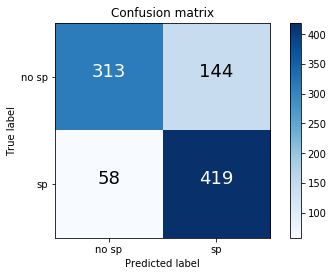

In [33]:
### with mixed Model
%matplotlib inline
print_test_accuracy(model = mixedModel, show_confusion_matrix=True, normalize = False, show_first_100_preds = False)

934/934 [==============================] - 189s 203ms/step
Accuracy on Test-Set: 78.4% (732 / 934)
Confusion Matrix:
[[313 144]
 [ 58 419]]
Normalized confusion matrix


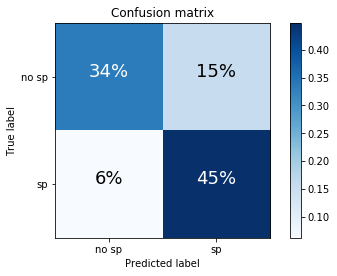

In [34]:
%matplotlib inline
print_test_accuracy(model = mixedModel, show_confusion_matrix=True, normalize = True, show_first_100_preds = False)

7946/7946 [==============================] - 1538s 194ms/step
Accuracy on Test-Set: 81.1% (6444 / 7946)
Confusion Matrix:
[[2659 1314]
 [ 188 3785]]
Normalized confusion matrix


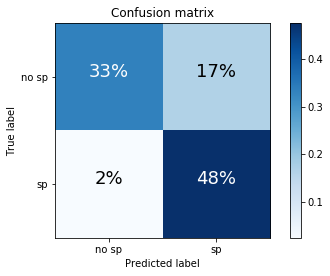

In [46]:
### with mixed model and cali data
print_test_accuracy(model = mixedModel, test_images = Btest_images, test_labels = Btest_labels, show_confusion_matrix=True, 
                    normalize = True, show_first_100_preds = False)

7946/7946 [==============================] - 1523s 192ms/step
Accuracy on Test-Set: 72.3% (5745 / 7946)
Confusion Matrix:
[[2760 1213]
 [ 988 2985]]
Normalized confusion matrix


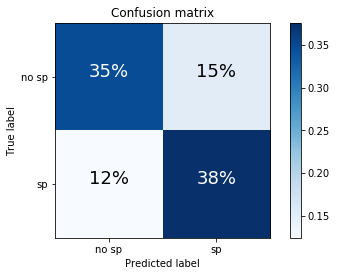

In [47]:
### with best of model and cali data
print_test_accuracy(model = boModel, test_images = Btest_images, test_labels = Btest_labels, show_confusion_matrix=True, 
                    normalize = True, show_first_100_preds = False)

934/934 [==============================] - 194s 207ms/step
Accuracy on Test-Set: 82.0% (766 / 934)
Example errors:


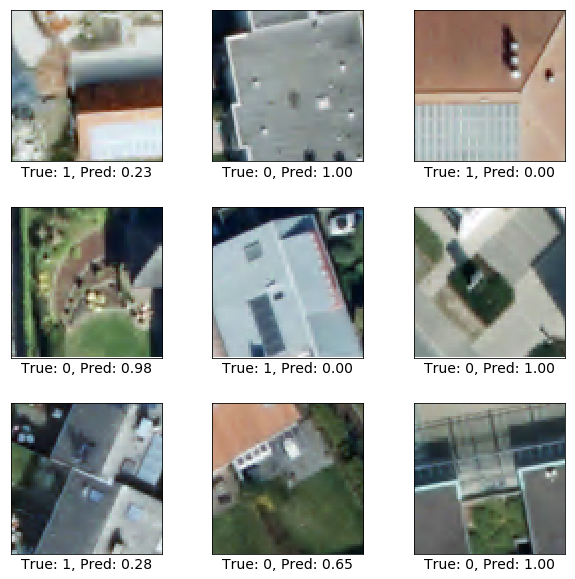

In [24]:
print_test_accuracy(show_example_errors=True, show_first_100_preds = False)

934/934 [==============================] - 1s 1ms/step
Accuracy on Test-Set: 82.0% (766 / 934)
Confusion Matrix:
[[332 125]
 [ 43 434]]
Confusion matrix, without normalization


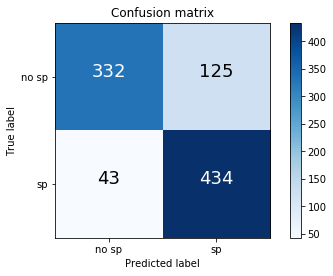

In [95]:
print_test_accuracy(show_confusion_matrix=True, normalize = False, show_first_100_preds = False)

934/934 [==============================] - 1s 1ms/step
Accuracy on Test-Set: 82.0% (766 / 934)
Confusion Matrix:
[[332 125]
 [ 43 434]]
Normalized confusion matrix


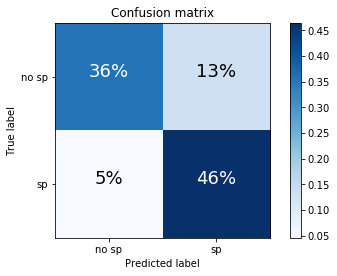

In [98]:
print_test_accuracy(show_confusion_matrix=True, show_first_100_preds = False)

934/934 [==============================] - 1s 1ms/step


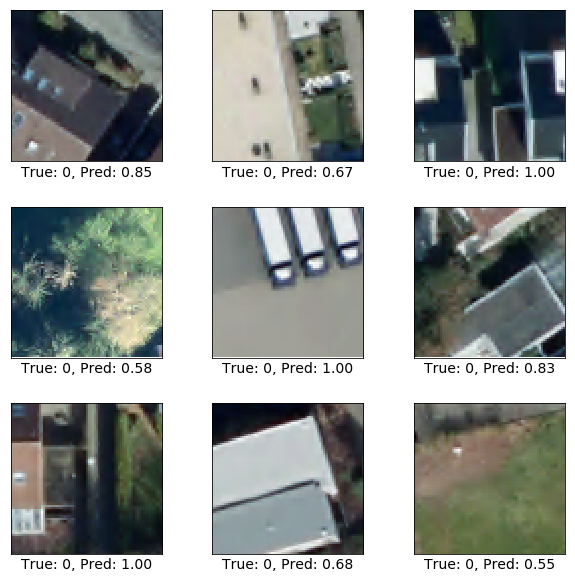

In [120]:
def plot_false_positives(test_images = test_images, test_labels = test_labels, model = boModel):
    predictions = model.predict(x = test_images, batch_size=128, verbose=1)
    cls_pred = np.array([np.round(el,0) for el in predictions]).flatten()
    predictions = np.array(["%.2f" % el for el in predictions]).flatten()
    cls_true = test_labels
    fps = ((cls_true - cls_pred) == -1)
    fns = ((cls_true - cls_pred) == 1)
    images = test_images[fps]
    cls_pred = predictions[fps]
    cls_true = test_labels[fps]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
plot_false_positives()

934/934 [==============================] - 1s 1ms/step


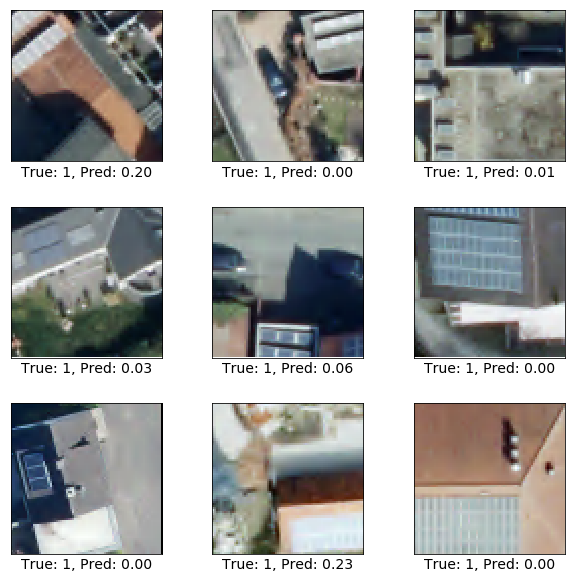

In [121]:
def plot_false_negatives(test_images = test_images, test_labels = test_labels, model = boModel):
    predictions = model.predict(x = test_images, batch_size=128, verbose=1)
    cls_pred = np.array([np.round(el,0) for el in predictions]).flatten()
    predictions = np.array(["%.2f" % el for el in predictions]).flatten()
    cls_true = test_labels
    fns = ((cls_true - cls_pred) == 1)
    images = test_images[fns]
    cls_pred = predictions[fns]
    cls_true = test_labels[fns]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
plot_false_negatives()

In [141]:
len(boModel.layers)
boModel.layers[:20]

135

In [164]:
def plot_weights(input_channel=0, layer_index = 1, model = boModel):
    print('Layer: {}, channel: {}'.format(layer_index, input_channel))
    w = model.layers[layer_index].get_weights()[0]
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            if layer_index ==1:
                img = w[:, :, :, i]
                ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest')
            else:
                img = w[:, :, input_channel, i]
                ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [176]:
for num in [1,4,7,10,12,17,20,22,27,30,32,37,40, 43, 47, 50, 53, 57, 60, 63, 67, 70, 73, 77, 80, 83]:    
    w = boModel.layers[num].get_weights()[0]
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    print(num_filters)
    if num_filters > 1:
        print(w.shape)

32
(3, 3, 3, 32)
64
(3, 3, 32, 64)
1
1
128
(1, 1, 64, 128)
1
1
256
(1, 1, 128, 256)
1
1
728
(1, 1, 256, 728)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [170]:
len(boModel.layers)

135

Layer: 1, channel: 0


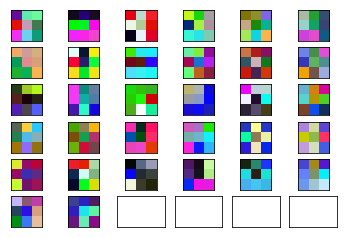

Layer: 4, channel: 0


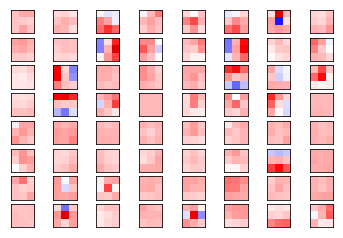

In [178]:
plot_weights(input_channel=0)
plot_weights(input_channel=0, layer_index=4)
# plot_weights(input_channel=0, layer_index=7)
# plot_weights(input_channel=0, layer_index=10)
# plot_weights(input_channel=0, layer_index=12)
# plot_weights(input_channel=0, layer_index=22)
# plot_weights(input_channel=0, layer_index=32)


In [154]:
for number in range(len(boModel.layers)):
    lname = boModel.layers[number]
    if 'conv' in str(lname):
        print('{} is {}'.format(number, lname))

1 is <keras.layers.convolutional.Conv2D object at 0x7fdf5b16d510>
4 is <keras.layers.convolutional.Conv2D object at 0x7fdf35809250>
7 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf358094d0>
10 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf358097d0>
12 is <keras.layers.convolutional.Conv2D object at 0x7fdf35809990>
17 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf35809dd0>
20 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf3581c110>
22 is <keras.layers.convolutional.Conv2D object at 0x7fdf3581c2d0>
27 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf3581c710>
30 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf3581ca10>
32 is <keras.layers.convolutional.Conv2D object at 0x7fdf3581cbd0>
37 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf34fa4050>
40 is <keras.layers.convolutional.SeparableConv2D object at 0x7fdf34fa4350>
43 is <keras.layers.convolutional.SeparableConv2D object at 

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

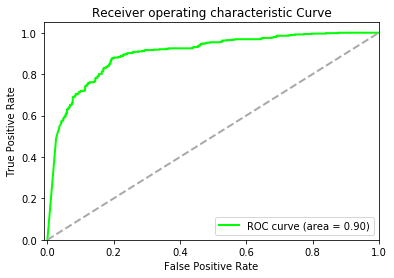

In [9]:
# calculating the ROC    
def print_ROC(model = boModel, color = 'lime'):
    y_pred = model.predict(test_images, batch_size = 64)
    y_true = test_labels
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color= color,
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
print_ROC()

In [52]:
os.chdir(model_dir)
nameList = os.listdir(model_dir)
myorder = [4,8,2,11,0,1,5,10,3,7,6,9]
nameList = [ nameList[i] for i in myorder]
nameList

['IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63',
 'IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__',
 'DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08',
 'Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imagenet_86_3-e19',
 'DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30',
 'DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04',
 'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16',
 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73',
 'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0001_e-48_imagenet_595_3-e29',
 'IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08',
 'IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04',
 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet

In [200]:
colorList = ['darkorange', 'orange', 'gold', 'navy', 'blue', 'royalblue', 'darkgreen', 'g', 'limegreen', \
             'darkred', 'firebrick', 'indianred']

In [9]:
from keras.models import load_model
os.chdir(model_dir)
el  =  'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63'
el2 =  'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16'
el3 =  'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0001_e-48_imagenet_595_3-e29'
first = load_model(el2, custom_objects={'precision': precision, 'recall': recall, 'fbeta_score': fbeta_score, 
                                           'fmeasure': fmeasure})

ValueError: bad marshal data (unknown type code)

IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63


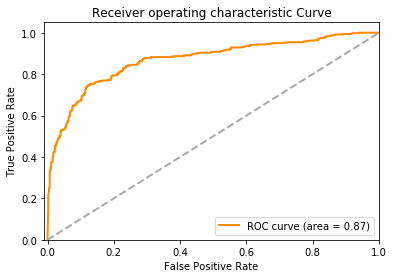

IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0001_e-48_imagenet_595_3-e29


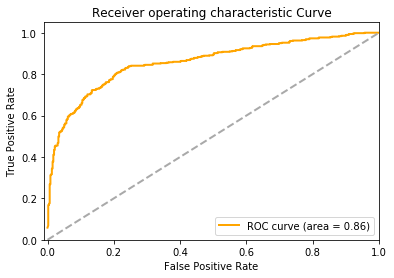

IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16


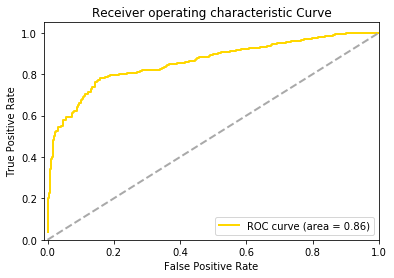

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04


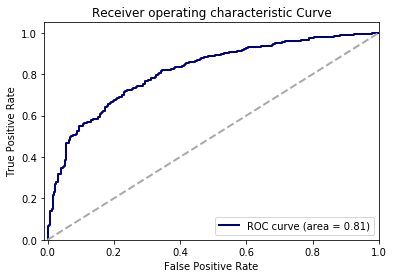

IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__


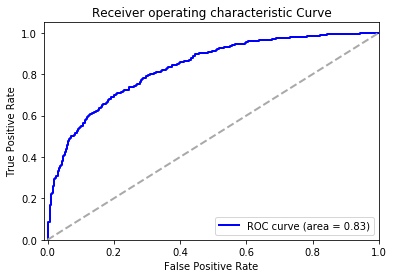

IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08


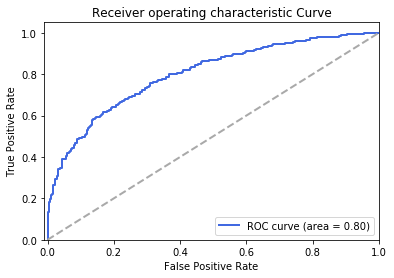

Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73


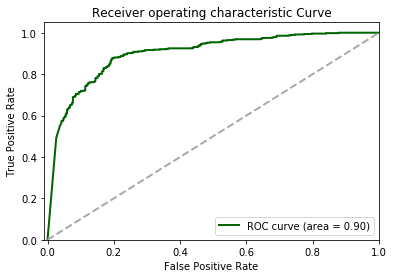

Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imagenet_86_3-e19


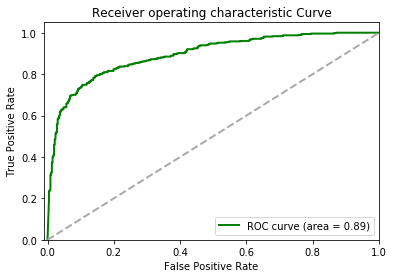

Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42


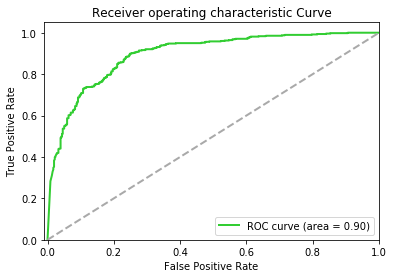

DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08


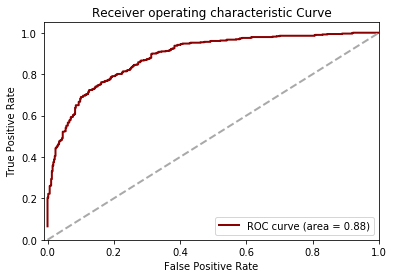

DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30


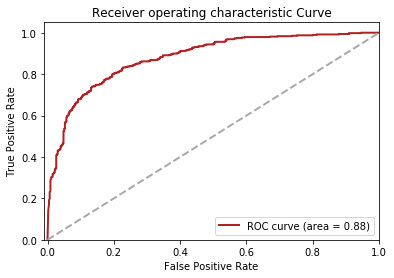

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04


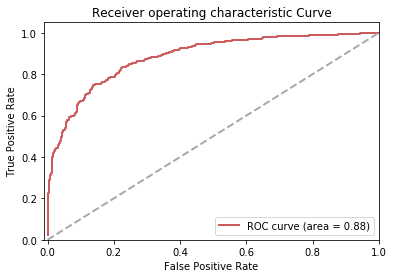

In [202]:
for num in range(12):
    el = nameList[num]
    color = colorList[num]
    model = load_model(el, custom_objects={'precision': precision, 'recall': recall, 'fbeta_score': fbeta_score, 
                                           'fmeasure': fmeasure})
    print(str(el))
    print_ROC(model, color = color)   

In [70]:
# calculating the AUC for every model
AUClist = []
def calcAUC(model = boModel):
    y_pred = model.predict(test_images, batch_size = 64)
    y_true = test_labels
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print('Auc value: {:.4f}'.format(float(roc_auc)))
    AUClist.append(roc_auc)
calcAUC()

Auc value: 0.8995


In [59]:
os.chdir(model_dir)
exceptIncResNet = [1,2,3,4,5,7,9,10,11]
for num in exceptIncResNet:
    el = nameList[num]
    print(el)
    model = load_model(str(el), custom_objects={'precision': precision, 'recall': recall, 'fbeta_score': fbeta_score, 
                                                'fmeasure': fmeasure})
    calcAUC(model)    

IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__
Auc value: 0.8318
DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08
Auc value: 0.8849
Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imagenet_86_3-e19
Auc value: 0.8932
DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30
Auc value: 0.8806
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04
Auc value: 0.8831
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73
Auc value: 0.8995
IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08
Auc value: 0.7995
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04
Auc value: 0.8133
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42
Auc value: 0.8960


In [69]:
import pandas as pd
AUCreduced = [round(i,4) for i in AUClist]
data = np.array(AUCreduced)
cols = ['auc']
rows = [nameList[i] for i in [1,2,3,4,5,7,9,10,11]]
AUCframe = pd.DataFrame(data = data, columns = cols, index = rows)
#AUCoverview = pd.DataFrame(data = AUCframe.transpose(), columns = cols, index = rows)
AUCframe.sort_values(by=['auc'], ascending = False)

,auc
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73,0.8995
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42,0.8960
Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imagenet_86_3-e19,0.8932
DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08,0.8849
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04,0.8831
DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30,0.8806
IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__,0.8318
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04,0.8133
IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08,0.7995
